In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split 
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel  
from torch.utils.data import Dataset, DataLoader

/Users/chigi/Developer/cd_ocr_code_runner/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading CSV (Ground Truth)

In [53]:
RAW_DATA_PATH = "dataset/rawdata.csv"
df = pd.read_csv(RAW_DATA_PATH)

In [54]:
df.head()

,Ground Truth,GCV,ED GCV,AWS,ED AWS,Azure,ED Azure,MP,ED MP
0,"num = int(input(""Enter a number: ""))\nAns = 1\...","int (input (""Enter a number: "")\nnum =\nAns =)...",29,"num = int input C ""Enter a number: 11)\nAns = ...",23,"num = int (input (""Enter a number: ""\nAns =1\n...",16,"num = int (input (""Enter a number: "")\n\[\n\te...",45
1,from karel.stanfordkarel import *\n# This prog...,from Karel. stanfordkarel import *\n#This\npro...,257,from Karel. stanfor dkarel import *\n# This pr...,195,from Karel. stanfordkarel import *\n# This pro...,177,from Karel.stanfordkarel import * \#This progr...,306
2,def main():\n # input\n my_word = input(...,"def main ()\n#imput\nmy _ word = imput(""Entlo-...",210,"def main () :\n# imput\nmy wond = inpuTC ""Ente...",150,def main ( ) :\nLimput\nmy _ word = input( Ent...,149,defmaim ():\n\&imput\n\( m y \)-wond = impuT (...,298
3,"input_number = int(input(""Enter number""))\nval...","impur-number =\nint(impur (""Enter number'))\nv...",80,impur-number =\ninr(inpur ('Enter number')\nva...,59,"inpur_number =\nint(impur (""Enter number""\nVal...",50,\( \begin{array}{l}\text { inpur-number = } \\...,273
4,"def main():\n num = input(""input: "")\n s...","def main ():\nnum = input (""imput :"")\nsum\n=\...",49,"def main () :\nnum = input (""Input: "")\nsum = ...",33,"def main () :\nnum = input (""Input : "")\nsum =...",34,def \( \operatorname{main}(C) \) :\n\[\n\begin...,132


## Load and Preprocess Images

In [55]:
IMAGE_PATH = "dataset/images/"

In [56]:
preprocessed_images = []
ground_truths = []

In [57]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (320, 128))
    img = img / 255.0 
    img = np.expand_dims(img, axis = -1) # add channel dimention for model input
    return img

In [58]:
for i, row in df.iterrows():
    img_path = IMAGE_PATH + f"{i}.jpg"
    preprocessed_images.append(preprocess_image(img_path))
    ground_truths.append(row["Ground Truth"])

In [59]:
preprocessed_images = np.array(preprocessed_images)

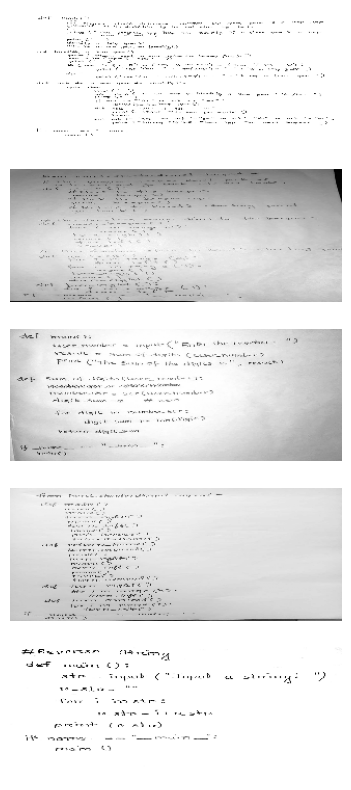

In [60]:
indices = np.random.choice(len(preprocessed_images), 5, replace = False)

plt.figure(figsize = (5, 10))
for i, idx in enumerate(indices):
    plt.subplot(5, 1, i + 1)
    plt.imshow(preprocessed_images[idx], cmap='gray') 
    plt.axis("off")
plt.show()

In [61]:
print(len(preprocessed_images))

55


In [62]:
print(preprocessed_images.shape)

(55, 128, 320, 1)


## Split Data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_images, 
    ground_truths, 
    test_size=0.2, 
    random_state=42
)

In [64]:
print(len(X_train))

44


In [65]:
print(len(X_test))

11


## Loading Models

In [81]:
model_path = "/Users/chigi/.cache/huggingface/hub/models--microsoft--trocr-base-handwritten/snapshots/eaacaf452b06415df8f10bb6fad3a4c11e609406"

In [19]:
processor = TrOCRProcessor.from_pretrained(model_path)

In [76]:
model = VisionEncoderDecoderModel.from_pretrained(model_path)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

In [99]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

## Fine Tuning Model

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
class OCRDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if image.shape[-1] == 1:  
            image = Image.fromarray(image.squeeze(-1)).convert("RGB")  

        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze(0)
        label_ids = self.processor.tokenizer(label, padding="max_length", truncation=True, max_length=128, return_tensors="pt")["input_ids"].squeeze(0)

        return {"pixel_values": pixel_values, "labels": label_ids}

In [102]:
train_dataset = OCRDataset(X_train, y_train, processor)
test_dataset = OCRDataset(X_test, y_test, processor)

In [103]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [104]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)

In [107]:
num_epochs = 5
best_loss = float("inf")
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
for epoch in range(num_epochs):
    print(f"\n[ Epoch {epoch + 1}/{num_epochs} ]")
    model.train()
    total_loss = 0
    batch_count = 0

    for batch in train_loader:
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

        print(f"  - Batch {batch_count}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_loader)
    print(f"  >> Training Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values, labels=labels)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    print(f"  >> Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        model.save_pretrained(save_dir)
        processor.save_pretrained(save_dir)
        print(f"  ✅ Best Model Saved at {save_dir} (Loss: {best_loss:.4f})")


[ Epoch 1/5 ]
  - Batch 2/11 | Loss: 8.5155
  - Batch 4/11 | Loss: 9.6381
  - Batch 6/11 | Loss: 8.2319
  - Batch 8/11 | Loss: 4.8123
  - Batch 10/11 | Loss: 6.0745
  >> Training Loss: 8.3089
  >> Validation Loss: 5.2959
  ✅ Best Model Saved at models (Loss: 5.2959)

[ Epoch 2/5 ]
  - Batch 2/11 | Loss: 4.8341
  - Batch 4/11 | Loss: 5.7379
  - Batch 6/11 | Loss: 4.5341
  - Batch 8/11 | Loss: 5.3042
  - Batch 10/11 | Loss: 5.3789
  >> Training Loss: 5.0245
  >> Validation Loss: 4.7103
  ✅ Best Model Saved at models (Loss: 4.7103)

[ Epoch 3/5 ]
  - Batch 2/11 | Loss: 5.9809
  - Batch 4/11 | Loss: 4.4945
  - Batch 6/11 | Loss: 4.7855
  - Batch 8/11 | Loss: 4.5819
  - Batch 10/11 | Loss: 3.7972
  >> Training Loss: 4.3274
  >> Validation Loss: 4.2276
  ✅ Best Model Saved at models (Loss: 4.2276)

[ Epoch 4/5 ]
  - Batch 2/11 | Loss: 5.1703
  - Batch 4/11 | Loss: 3.7393
  - Batch 6/11 | Loss: 3.5330
  - Batch 8/11 | Loss: 3.0496
  - Batch 10/11 | Loss: 3.4616
  >> Training Loss: 3.8030
  >